In [ ]:
!pip install tensorflow

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
import PIL

from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from matplotlib import pyplot

In [ ]:
!unzip train_datasets.zip

Archive:  train_datasets.zip
   creating: train_datasets/breast/
   creating: train_datasets/breast/high_quality/
  inflating: train_datasets/breast/high_quality/1213.png  
  inflating: train_datasets/breast/high_quality/1214.png  
  inflating: train_datasets/breast/high_quality/1215.png  
  inflating: train_datasets/breast/high_quality/1216.png  
  inflating: train_datasets/breast/high_quality/1217.png  
  inflating: train_datasets/breast/high_quality/1218.png  
  inflating: train_datasets/breast/high_quality/1219.png  
  inflating: train_datasets/breast/high_quality/1220.png  
  inflating: train_datasets/breast/high_quality/1221.png  
  inflating: train_datasets/breast/high_quality/1222.png  
  inflating: train_datasets/breast/high_quality/1223.png  
  inflating: train_datasets/breast/high_quality/1224.png  
  inflating: train_datasets/breast/high_quality/1225.png  
  inflating: train_datasets/breast/high_quality/1226.png  
  inflating: train_datasets/breast/high_quality/1227.png  
 

In [ ]:
low_quality_path = "/content/train_datasets/breast/low_quality"
high_quality_path = "/content/train_datasets/breast/high_quality"

In [ ]:
from os import listdir
from PIL import Image
from IPython.display import display
from numpy import asarray, expand_dims, array

train_set_low_quality = []
train_set_high_quality = []
for img in os.listdir(low_quality_path):
    if (img.endswith(".png")):
       image = Image.open(os.path.join(low_quality_path, img)).convert("L")
       image = image.resize((256, 256))
       image = expand_dims(asarray(image), axis=-1)
       train_set_low_quality.append(image)
for img in os.listdir(high_quality_path):
    if (img.endswith(".png")):
        image = Image.open(os.path.join(high_quality_path, img)).convert("L")
        image = image.resize((256, 256))
        image = expand_dims(asarray(image), axis=-1)
        train_set_high_quality.append(image)
train_set = [asarray(train_set_low_quality), asarray(train_set_high_quality)]

array([[  0,   0,   0, ...,   0,   0,   0],
       [ 14,  18,  21, ...,  18,  22,  20],
       [104, 126, 137, ..., 124, 128, 113],
       ...,
       [  2,   7,  10, ...,  18,  22,  20],
       [  3,   7,  10, ...,  17,  20,  15],
       [  6,   9,   8, ...,   9,   8,   4]], dtype=uint8)
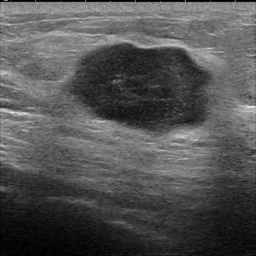

array([[166, 162, 163, ..., 154, 149, 136],
       [163, 161, 157, ..., 141, 150, 154],
       [169, 166, 155, ..., 148, 155, 154],
       ...,
       [ 29,  22,  33, ...,   8,   8,   8],
       [ 25,  19,  18, ...,  10,  11,  15],
       [ 42,  39,  26, ...,   9,  11,  15]], dtype=uint8)
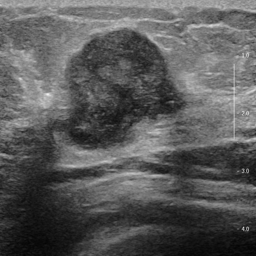

In [ ]:
display(train_set_low_quality[0].squeeze())
display(train_set_high_quality[0].squeeze())

In [ ]:
train_set[0].shape

(202, 256, 256, 1)

In [ ]:
train_set[1].shape

(202, 256, 256, 1)

In [ ]:
def define_discriminator(image_shape):
	init = RandomNormal(stddev=0.02)
	in_src_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)
	merged = Concatenate()([in_src_image, in_target_image])
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	model = Model([in_src_image, in_target_image], patch_out)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	g = BatchNormalization()(g, training=True)
	if dropout:
		g = Dropout(0.5)(g, training=True)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

def define_generator(image_shape=(256,256,1)):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	model = Model(in_image, out_image)
	return model

In [ ]:
def define_gan(g_model, d_model, image_shape):
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	in_src = Input(shape=image_shape)
	gen_out = g_model(in_src)
	dis_out = d_model([in_src, gen_out])
	model = Model(in_src, [dis_out, gen_out])
	opt = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
train_set_1, train_set_2 = train_set[0], train_set[1]
train_set_1 = (train_set_1 - 127.5) / 127.5
train_set_2 = (train_set_2 - 127.5) / 127.5

In [ ]:
def generate_random_training_samples(data, n_samples, n_patch):

    train_A, train_B = data
    n = randint(0, train_A.shape[0], n_samples)
    X1, X2 = train_A[n], train_B[n]
    y = ones((n_samples, n_patch, n_patch, 1))

    return [X1, X2], y

def generate_fake_samples(generator_model, samples, n_patch):
    print(samples.shape)
    X = generator_model.predict(samples)
    y = zeros((len(X), n_patch, n_patch, 1))
    return X, y

def load_real_samples():
		return [train_set_1, train_set_2]

def save_model(step, g_model, d_model, gan_model, model_dest):
    filename1 = model_dest + ('model_g_%06d.h5' % (step+1))
    g_model.save(filename1)
    filename2 = model_dest + ('model_d_%06d.h5' % (step+1))
    d_model.save(filename2)
    filename3 = model_dest + ('model_gan_%06d.h5' % (step+1))
    gan_model.save(filename3)
    print('Models successfully saved at step: %d' % (step))


In [ ]:
import tensorflow as tf
import keras
from keras.models import load_model

def train(discriminator_model, generator_model, gan_model, data, model_dest, n_epochs=200, n_batch=1, n_patch=16, random_jitter=False, current_step=0):
	train_A, train_B = data
	batches_per_epoch = int((len(train_A)) / n_batch)
	n_steps = batches_per_epoch*n_epochs
	print(n_steps, batches_per_epoch)
	for i in range(current_step, n_steps):
		[X_real_A, X_real_B], y_real = generate_random_training_samples(data, n_batch, n_patch)
		if random_jitter==True:
			input_image = tf.image.resize(X_real_A, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
			real_image = tf.image.resize(X_real_B, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
			stacked_image = tf.stack([input_image, real_image], axis=0)
			cropped_image = tf.image.random_crop( stacked_image, size=[2, 1, 256, 256, 3])
			X_real_A, X_real_B = cropped_image[0], cropped_image[1]
			X_real_A = keras.backend.eval(X_real_A)
			X_real_B = keras.backend.eval(X_real_B)


		X_fake, y_fake = generate_fake_samples(generator_model, X_real_A, n_patch)
		discriminator_loss_real = discriminator_model.train_on_batch([X_real_A, X_real_B], y_real)
		discriminator_loss_generated = discriminator_model.train_on_batch([X_real_A, X_fake], y_fake)
		generator_loss, a, b = gan_model.train_on_batch(X_real_A, [y_real, X_real_B])
		print('%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, discriminator_loss_real, discriminator_loss_generated, generator_loss))

		if (i+1) % (batches_per_epoch * 10) == 0:
			save_model(i, generator_model, discriminator_model, gan_model, model_dest)


def start_training(dataset_url, model_dest):
	train_generator = load_real_samples()
	print('Dataset Loaded', train_generator[0].shape, train_generator[1].shape)
	image_shape = train_set[0].shape[1:]
	d_model = define_discriminator(image_shape)
	g_model = define_generator(image_shape)
	gan_model = define_gan(g_model, d_model, image_shape)
	train(d_model, g_model, gan_model, train_generator, model_dest)

def resume_training(step, dataset_url, d_model_src, g_model_src, gan_model_src, model_dest):
	d_model = load_model(d_model_src)
	g_model = load_model(g_model_src)
	gan_model = load_model(gan_model_src)
	dataset = load_real_samples()
	train(d_model, g_model, gan_model, dataset, model_dest, current_step=step)

dataset_url = ""
model_dest = "/content/"

start_training(dataset_url, model_dest)

# call to resume training from a particular step e.g. 153440
step = 153440
d_model_src = model_dest + 'model_d_' + str(step) + '.h5'
g_model_src = model_dest + 'model_g_' + str(step) + '.h5'
gan_model_src = model_dest + 'model_gan_' + str(step) + '.h5'


Dataset Loaded (202, 256, 256) (202, 256, 256)
40400 202
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
354, d1[0.474] d2[0.474] g[22.794]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
355, d1[0.474] d2[0.474] g[22.787]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
356, d1[0.474] d2[0.475] g[22.772]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
357, d1[0.474] d2[0.475] g[22.764]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
358, d1[0.474] d2[0.475] g[22.775]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
359, d1[0.474] d2[0.475] g[22.767]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
360, d1[0.475] d2[0.475] g[22.770]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
361, d1[0.475] d2[0.475] g[22.765]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
362, d1[0.475] d2[0.475] g[22.776]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
363, d1[0.475] d2[0.476] g[22.784]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
364, d1[0.475] d2[0.476] g[22.

2020, d1[0.594] d2[0.594] g[18.883]


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
2374, d1[0.609] d2[0.609] g[18.222]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
2375, d1[0.609] d2[0.609] g[18.219]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
2376, d1[0.609] d2[0.609] g[18.218]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
2377, d1[0.609] d2[0.609] g[18.218]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
2378, d1[0.609] d2[0.609] g[18.217]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
2379, d1[0.609] d2[0.609] g[18.216]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
2380, d1[0.609] d2[0.609] g[18.213]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
2381, d1[0.609] d2[0.609] g[18.212]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
2382, d1[0.609] d2[0.609] g[18.210]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
2383, d1[0.609] d2[0.609] g[18.208]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
2384, d1[0.609] d2[0

4040, d1[0.667] d2[0.667] g[15.964]


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
4394, d1[0.678] d2[0.678] g[15.591]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
4395, d1[0.678] d2[0.678] g[15.590]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
4396, d1[0.678] d2[0.678] g[15.589]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
4397, d1[0.678] d2[0.678] g[15.588]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
4398, d1[0.678] d2[0.678] g[15.586]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
4399, d1[0.678] d2[0.678] g[15.585]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
4400, d1[0.678] d2[0.678] g[15.584]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
4401, d1[0.678] d2[0.678] g[15.582]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
4402, d1[0.678] d2[0.678] g[15.581]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
4403, d1[0.678] d2[0.678] g[15.580]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
4404, d1[0.678] d2[0

6060, d1[0.728] d2[0.728] g[14.129]


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
6414, d1[0.739] d2[0.739] g[13.870]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
6415, d1[0.739] d2[0.739] g[13.869]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
6416, d1[0.739] d2[0.739] g[13.868]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
6417, d1[0.739] d2[0.739] g[13.868]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
6418, d1[0.739] d2[0.739] g[13.867]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
6419, d1[0.739] d2[0.739] g[13.866]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
6420, d1[0.739] d2[0.739] g[13.865]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
6421, d1[0.739] d2[0.739] g[13.865]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
6422, d1[0.739] d2[0.739] g[13.864]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
6423, d1[0.739] d2[0.739] g[13.863]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
6424, d1[0.739] d2[0

8080, d1[0.787] d2[0.787] g[12.828]


Models successfully saved at step: 8079
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
8081, d1[0.787] d2[0.787] g[12.827]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
8082, d1[0.787] d2[0.787] g[12.826]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
8083, d1[0.787] d2[0.787] g[12.826]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
8084, d1[0.787] d2[0.788] g[12.825]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
8085, d1[0.787] d2[0.788] g[12.825]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
8086, d1[0.787] d2[0.788] g[12.824]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
8087, d1[0.788] d2[0.788] g[12.823]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
8088, d1[0.788] d2[0.788] g[12.823]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
8089, d1[0.788] d2[0.788] g[12.822]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
8090, d1[0.788] d2[0.788] g[12.822]
(1, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
8091, d1[0.788] d2[0

KeyboardInterrupt: 

In [ ]:
resume_training(step, dataset_url, d_model_src, g_model_src, gan_model_src, model_dest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(256, 256)


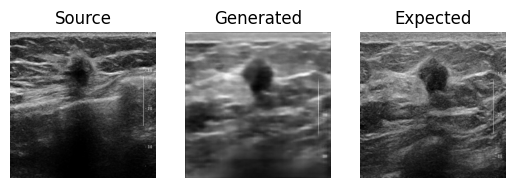

In [ ]:

from numpy import vstack
from matplotlib import pyplot
from keras.models import load_model

g_model = load_model("/content/model_g_008080.h5")
ix = randint(0, len(train_set_1), 1)
src_image, tar_image = train_set_1[ix][0], train_set_2[ix][0]
gen_image = g_model.predict(train_set_1[ix])

gen_image = gen_image.squeeze()
print(gen_image.shape)
src_image = (src_image + 1) / 2.0
tar_image = (tar_image + 1) / 2.0

titles = ['Source', 'Generated', 'Expected']
images = [src_image, gen_image, tar_image]
for i in range(3):
    pyplot.subplot(1, 3, i + 1)
    pyplot.axis('off')
    pyplot.imshow(images[i], cmap='gray')
    pyplot.title(titles[i])
pyplot.show()